### Setup & Download Data


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, AAPL)    2264 non-null   float64
 1   (High, AAPL)    2264 non-null   float64
 2   (Low, AAPL)     2264 non-null   float64
 3   (Close, AAPL)   2264 non-null   float64
 4   (Volume, AAPL)  2264 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.1 KB
None
Price            Open       High        Low      Close     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.746228  24.757336  23.848707  24.288582  212818400
2015-01-05  24.057533  24.137511  23.417718  23.604330  257142000
2015-01-06  23.668760  23.866481  23.244437  23.606556  263188400
2015-01-07  23.815385  24.037543  23.704305  23.937572  160423600
2015-01-08  24.266363  24.915065  24.14861

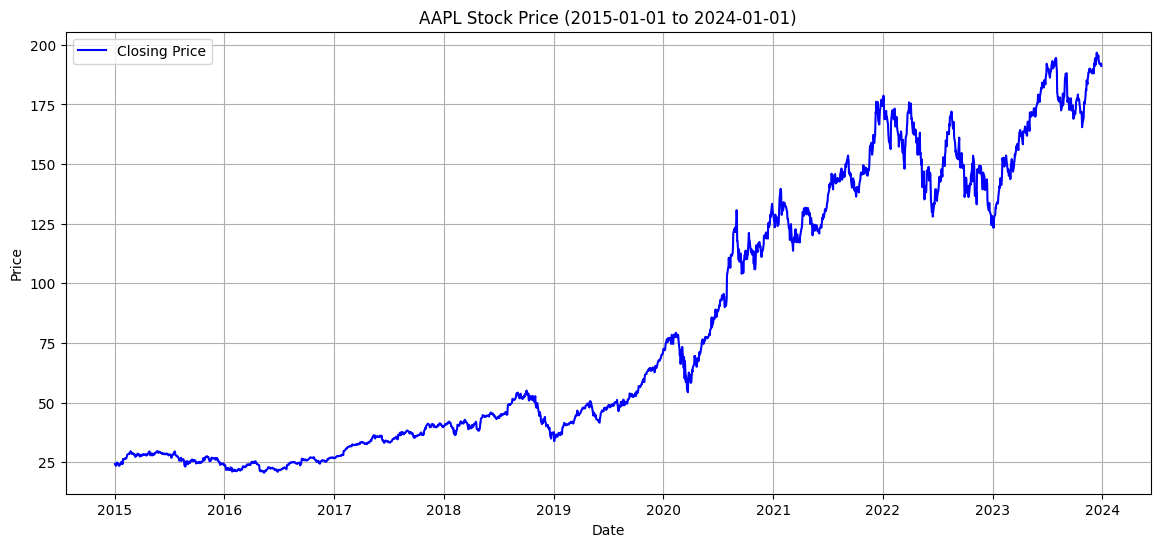

In [40]:
# STEP 1: Install and import necessary libraries
!pip install yfinance pandas matplotlib seaborn plotly

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# STEP 2: Download historical stock data
# You can change 'AAPL' to any stock symbol, and adjust the date range
symbol = 'AAPL'  # Apple Inc.
start_date = '2015-01-01'
end_date = '2024-01-01'

data = yf.download(symbol, start=start_date, end=end_date)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace=True)

# STEP 3: Basic Info & Preview
print(data.info())
print(data.head())

# STEP 4: Plot the closing price
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.title(f'{symbol} Stock Price ({start_date} to {end_date})')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


### Preprocessing & Seasonality Analysis

Missing values:
 Price   Ticker
Open    AAPL      0
High    AAPL      0
Low     AAPL      0
Close   AAPL      0
Volume  AAPL      0
dtype: int64


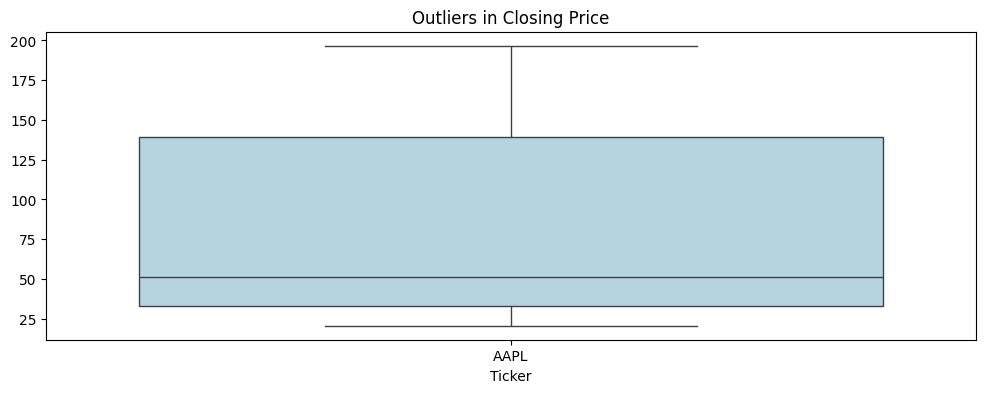

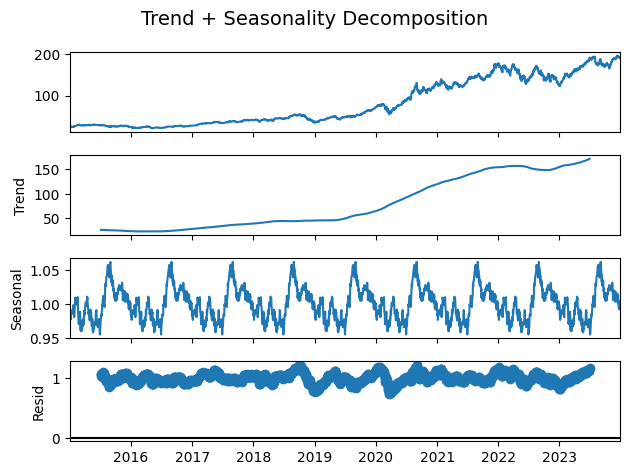

<Figure size 1200x400 with 0 Axes>

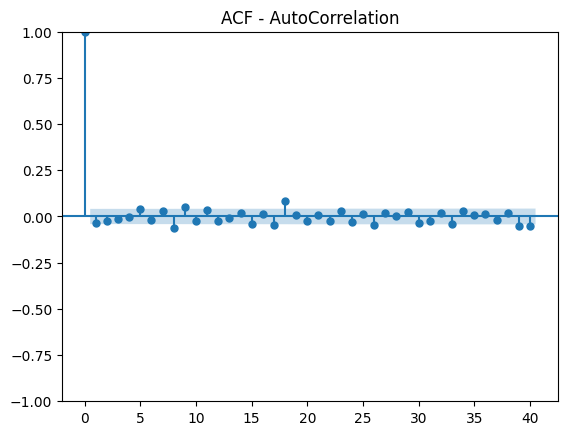

<Figure size 1200x400 with 0 Axes>

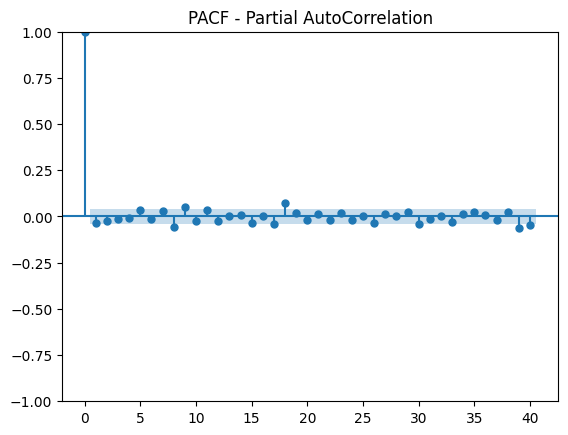

In [41]:
# STEP 2.1: Check for missing values
print("Missing values:\n", data.isnull().sum())

# STEP 2.2: Visualize basic statistics
plt.figure(figsize=(12, 4))
sns.boxplot(data['Close'], color='lightblue')
plt.title('Outliers in Closing Price')
plt.show()

# STEP 2.3: Decompose time series (Trend, Seasonality, Residual)
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model='multiplicative', period=252)  # approx. 1 trading year
result.plot()
plt.suptitle("Trend + Seasonality Decomposition", fontsize=14)
plt.tight_layout()
plt.show()

# STEP 2.4: ACF and PACF plots (For ARIMA/SARIMA tuning)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))
plot_acf(data['Close'].diff().dropna(), lags=40)
plt.title("ACF - AutoCorrelation")
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(data['Close'].diff().dropna(), lags=40)
plt.title("PACF - Partial AutoCorrelation")
plt.show()


### ARIMA Forecasting


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6438.180, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6437.240, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6433.778, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6433.742, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6439.641, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6435.086, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6435.711, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6436.854, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6436.693, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.503 seconds
Best ARIMA order: (0, 1, 1)


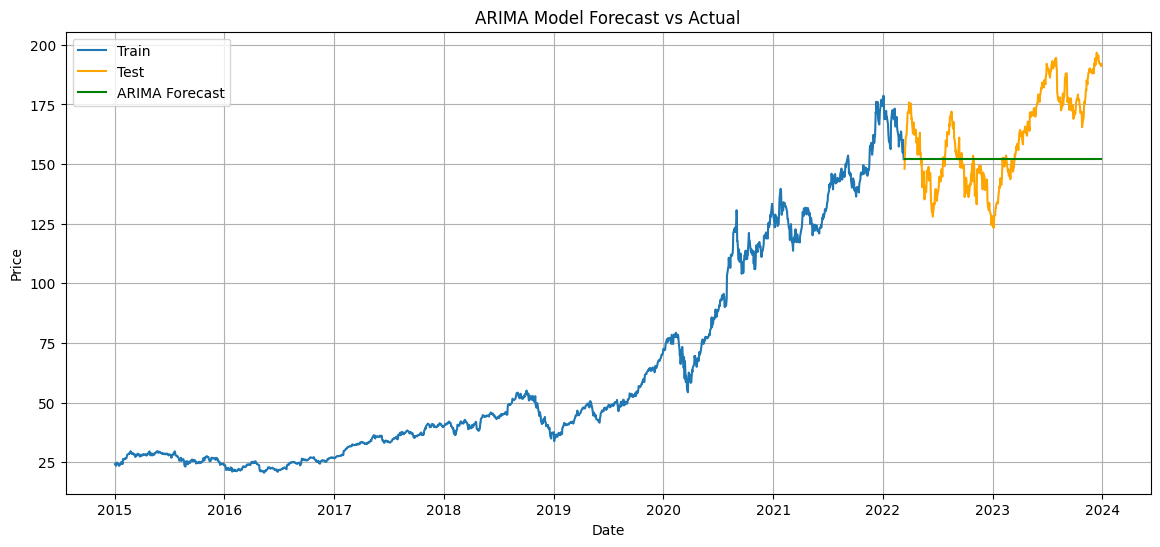

ARIMA MAE: 16.93
ARIMA RMSE: 20.59


In [42]:
# Install pmdarima if not already installed
!pip install pmdarima

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# STEP 3.1.1: Train-test split
#train_size = int(len(data) * 0.8)
train = data['Close'][:-90]
test = data['Close'][-90:]


train, test = data['Close'][:train_size], data['Close'][train_size:]

# STEP 3.1.2: Auto ARIMA to find best (p,d,q)
auto_model = auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)
print("Best ARIMA order:", auto_model.order)

# STEP 3.1.3: Fit model and forecast
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=auto_model.order)
arima_result = arima_model.fit()

forecast_steps = len(test)
arima_forecast = arima_result.forecast(steps=forecast_steps)
arima_forecast.index = test.index

# STEP 3.1.4: Plot forecast vs actual
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.title("ARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# STEP 3.1.5: Evaluate accuracy
mae_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"ARIMA MAE: {mae_arima:.2f}")
print(f"ARIMA RMSE: {rmse_arima:.2f}")


### SARIMA Forecasting

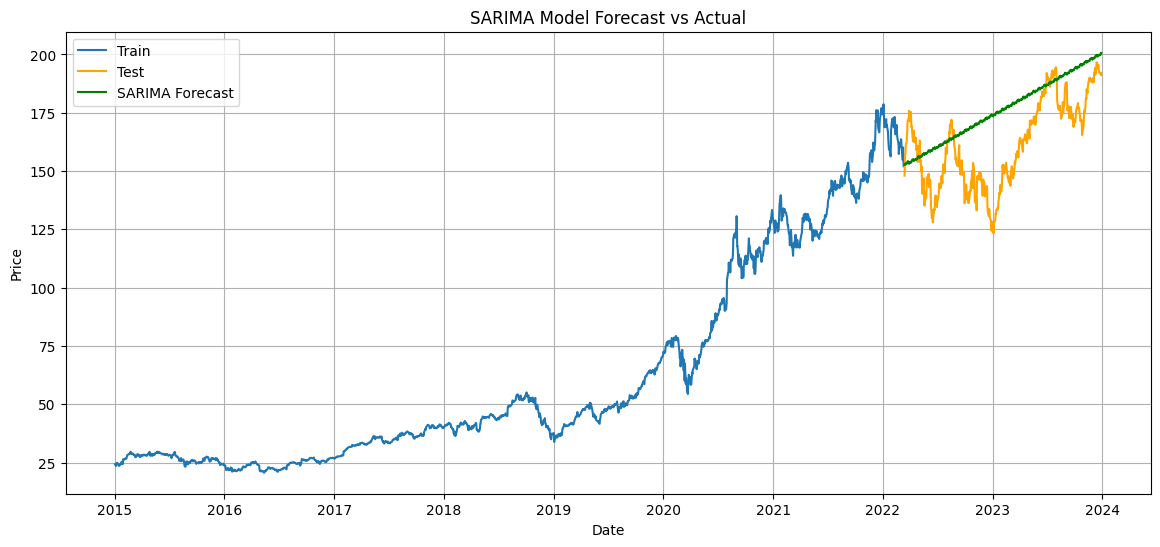

SARIMA MAE: 17.30
SARIMA RMSE: 20.55


In [43]:
# STEP 3.2: SARIMA (Seasonal ARIMA)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model (you can adjust these orders if needed)
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(test))
sarima_forecast.index = test.index  # align index

# Plot
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='green')
plt.title("SARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
mae_sarima = mean_absolute_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))
print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")


### Prophet Forecasting


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[*********************100%***********************]  1 of 1 completed


14:57:21 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing


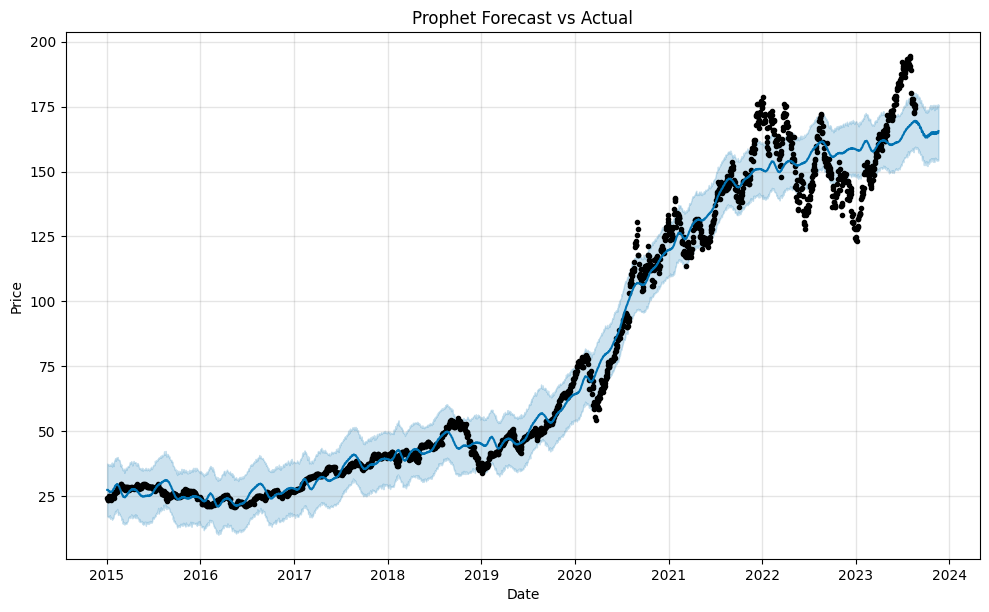

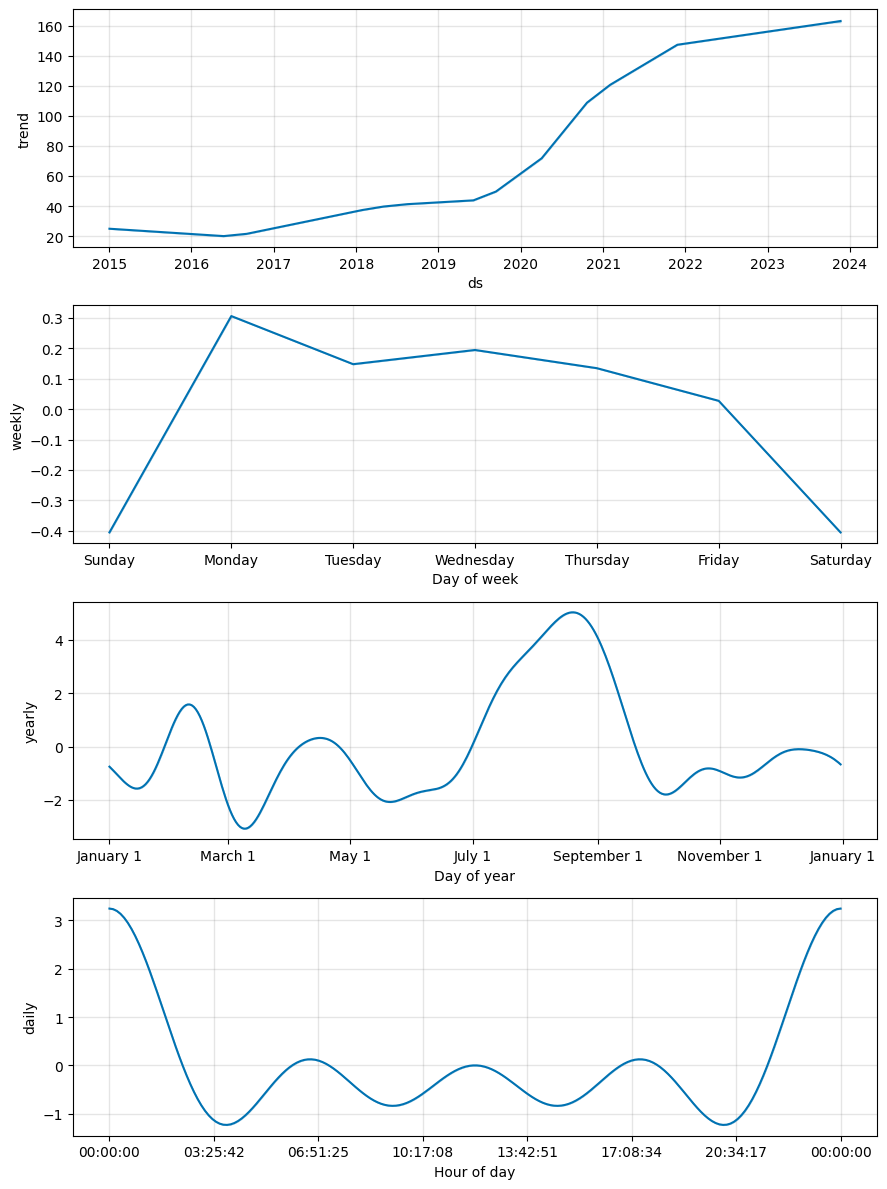

Prophet MAE: 15.88
Prophet RMSE: 18.14


In [44]:
# STEP 1: Install Prophet (if not already installed)
!pip install prophet yfinance

# STEP 2: Imports
from prophet import Prophet
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# STEP 3: Load the stock data
symbol = 'AAPL'
df = yf.download(symbol, start='2015-01-01', end='2024-01-01')[['Close']].dropna()

# STEP 4: Prepare data for Prophet
prophet_df = df.reset_index()[['Date', 'Close']]
prophet_df.columns = ['ds', 'y']  # Prophet requires these column names

# STEP 5: Train/Test Split
train = prophet_df[:-90]
test = prophet_df[-90:]

# STEP 6: Fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train)

# STEP 7: Make future dataframe & forecast
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# STEP 8: Plot the forecast
fig1 = model.plot(forecast)
plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# STEP 9: Plot forecast components (trend + seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# STEP 10: Evaluation
forecast_final = forecast[['ds', 'yhat']].set_index('ds').iloc[-90:]
actual_final = test.set_index('ds')['y']

mae_prophet = mean_absolute_error(actual_final, forecast_final['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(actual_final, forecast_final['yhat']))
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")


### LSTM Model for Stock Forecasting


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[*********************100%***********************]  1 of 1 completed

Epoch 1/10


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0327
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.7692e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.8803e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.3886e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.5320e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.7256e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.9761e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.6525e-04
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.0677e-04
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.5985e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


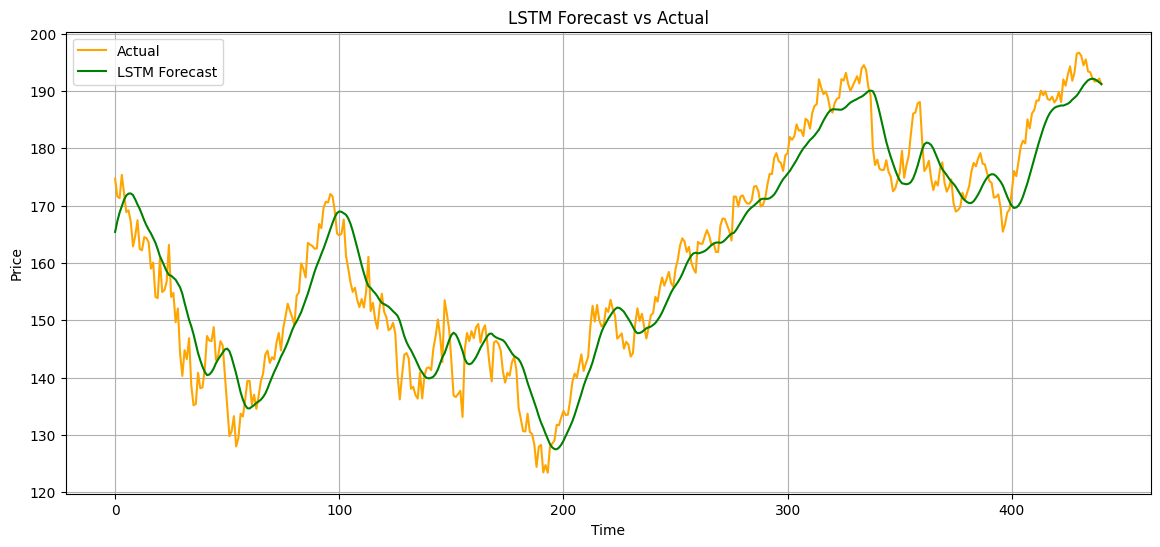

LSTM MAE: 4.46
LSTM RMSE: 5.35


In [45]:
# STEP 1: Install and import
!pip install yfinance tensorflow scikit-learn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings("ignore")

# STEP 2: Load data
symbol = 'AAPL'
data = yf.download(symbol, start='2015-01-01', end='2024-01-01')
data = data[['Close']].dropna()

# STEP 3: Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# STEP 4: Create sequences for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)

# STEP 5: Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# STEP 6: Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# STEP 7: Make predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)

# STEP 8: Plot results
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual', color='orange')
plt.plot(predicted, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# STEP 9: Evaluate
mae_lstm = mean_absolute_error(actual, predicted)
rmse_lstm = np.sqrt(mean_squared_error(actual, predicted))
print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")


### Model Comparison Table & Plot

In [48]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# ARIMA
actual_arima = actual_final[-30:]
arima_forecast_last30 = arima_forecast[-30:]
mae_arima = mean_absolute_error(actual_arima, arima_forecast_last30)
rmse_arima = np.sqrt(mean_squared_error(actual_arima, arima_forecast_last30))
mape_arima = mean_absolute_percentage_error(actual_arima, arima_forecast_last30) * 100
r2_arima = r2_score(actual_arima, arima_forecast_last30)

# SARIMA
sarima_forecast_last30 = sarima_forecast[-30:]
mae_sarima = mean_absolute_error(actual_arima, sarima_forecast_last30)
rmse_sarima = np.sqrt(mean_squared_error(actual_arima, sarima_forecast_last30))
mape_sarima = mean_absolute_percentage_error(actual_arima, sarima_forecast_last30) * 100
r2_sarima = r2_score(actual_arima, sarima_forecast_last30)

# Prophet
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds')[-30:]
actual_prophet = prophet_df.set_index('ds')['y'][-30:]
mae_prophet = mean_absolute_error(actual_prophet, prophet_forecast['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(actual_prophet, prophet_forecast['yhat']))
mape_prophet = mean_absolute_percentage_error(actual_prophet, prophet_forecast['yhat']) * 100
r2_prophet = r2_score(actual_prophet, prophet_forecast['yhat'])

# LSTM
mae_lstm = mean_absolute_error(actual, predicted)
rmse_lstm = np.sqrt(mean_squared_error(actual, predicted))
mape_lstm = mean_absolute_percentage_error(actual, predicted) * 100
r2_lstm = r2_score(actual, predicted)

# Print Results
print("\n📊 Model Evaluation (Last 30 Days Forecast)")
print(f"ARIMA   - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.2f}%, R²: {r2_arima:.2f}")
print(f"SARIMA  - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}, MAPE: {mape_sarima:.2f}%, R²: {r2_sarima:.2f}")
print(f"Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}, MAPE: {mape_prophet:.2f}%, R²: {r2_prophet:.2f}")
print(f"LSTM    - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%, R²: {r2_lstm:.2f}")



📊 Model Evaluation (Last 30 Days Forecast)
ARIMA   - MAE: 39.28, RMSE: 39.36, MAPE: 20.49%, R²: -221.25
SARIMA  - MAE: 7.37, RMSE: 7.68, MAPE: 3.86%, R²: -7.45
Prophet - MAE: 26.66, RMSE: 26.79, MAPE: 13.90%, R²: -101.95
LSTM    - MAE: 4.46, RMSE: 5.35, MAPE: 2.84%, R²: 0.92


In [49]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# ARIMA
actual_arima = actual_final[-90:]
arima_forecast_last90 = arima_forecast[-90:]
mae_arima = mean_absolute_error(actual_arima, arima_forecast_last90)
rmse_arima = np.sqrt(mean_squared_error(actual_arima, arima_forecast_last90))
mape_arima = mean_absolute_percentage_error(actual_arima, arima_forecast_last90) * 100
r2_arima = r2_score(actual_arima, arima_forecast_last90)

# SARIMA
sarima_forecast_last90 = sarima_forecast[-90:]
mae_sarima = mean_absolute_error(actual_arima, sarima_forecast_last90)
rmse_sarima = np.sqrt(mean_squared_error(actual_arima, sarima_forecast_last90))
mape_sarima = mean_absolute_percentage_error(actual_arima, sarima_forecast_last90) * 100
r2_sarima = r2_score(actual_arima, sarima_forecast_last90)

# Prophet
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds')[-90:]
actual_prophet = prophet_df.set_index('ds')['y'][-90:]
mae_prophet = mean_absolute_error(actual_prophet, prophet_forecast['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(actual_prophet, prophet_forecast['yhat']))
mape_prophet = mean_absolute_percentage_error(actual_prophet, prophet_forecast['yhat']) * 100
r2_prophet = r2_score(actual_prophet, prophet_forecast['yhat'])

# LSTM (assuming your LSTM test set is also last 90 days; adjust if needed)
mae_lstm = mean_absolute_error(actual, predicted)
rmse_lstm = np.sqrt(mean_squared_error(actual, predicted))
mape_lstm = mean_absolute_percentage_error(actual, predicted) * 100
r2_lstm = r2_score(actual, predicted)

# Print Results
print("\n📊 Model Evaluation (Last 90 Days Forecast)")
print(f"ARIMA   - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.2f}%, R²: {r2_arima:.2f}")
print(f"SARIMA  - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}, MAPE: {mape_sarima:.2f}%, R²: {r2_sarima:.2f}")
print(f"Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}, MAPE: {mape_prophet:.2f}%, R²: {r2_prophet:.2f}")
print(f"LSTM    - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%, R²: {r2_lstm:.2f}")


📊 Model Evaluation (Last 90 Days Forecast)
ARIMA   - MAE: 29.02, RMSE: 30.27, MAPE: 15.82%, R²: -11.37
SARIMA  - MAE: 14.44, RMSE: 16.06, MAPE: 8.16%, R²: -2.48
Prophet - MAE: 15.88, RMSE: 18.14, MAPE: 8.55%, R²: -3.44
LSTM    - MAE: 4.46, RMSE: 5.35, MAPE: 2.84%, R²: 0.92


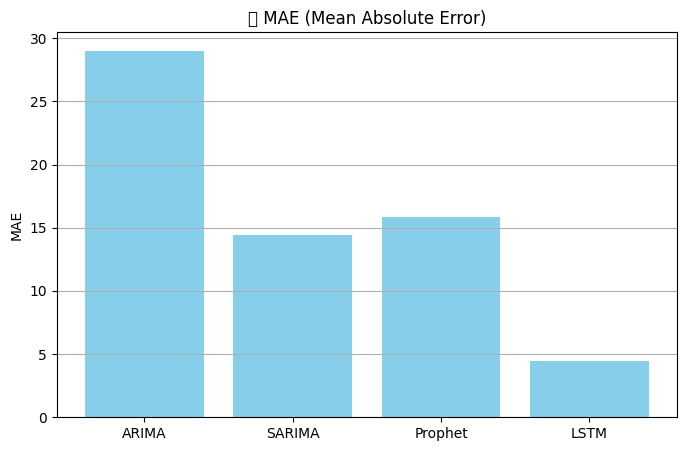

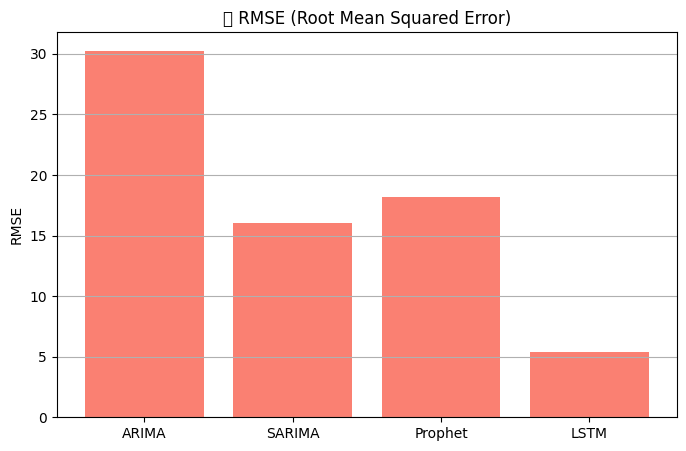

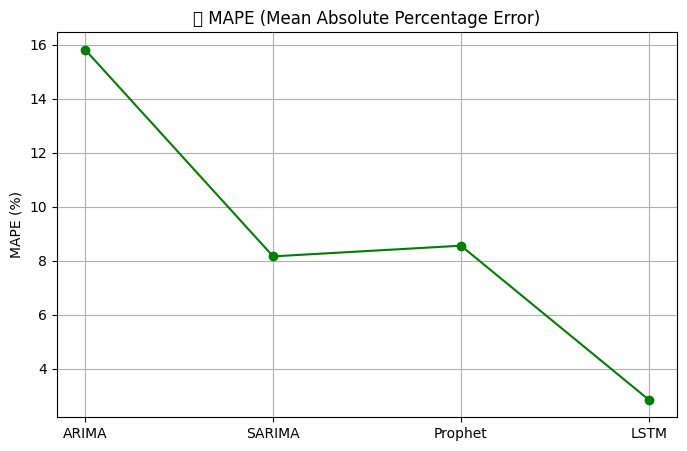

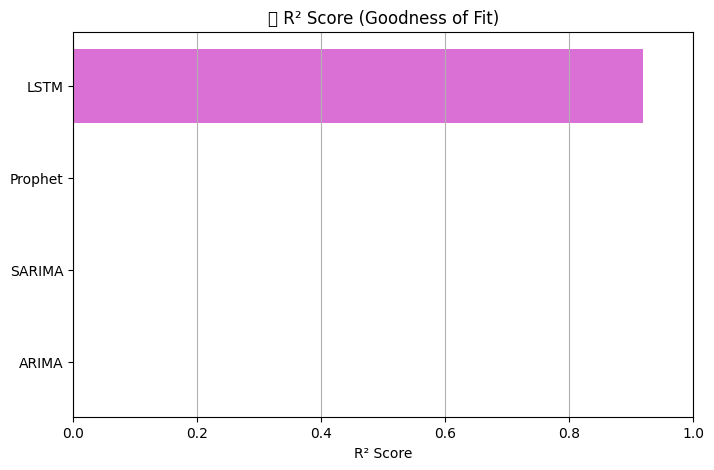

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a dictionary from your metrics
model_names = [ 'ARIMA', 'SARIMA','Prophet', 'LSTM']

mae_vals = [mae_arima, mae_sarima,mae_prophet, mae_lstm]
rmse_vals = [rmse_arima, rmse_sarima,rmse_prophet, rmse_lstm]
mape_vals = [mape_arima, mape_sarima,mape_prophet, mape_lstm]
r2_vals = [r2_arima, r2_sarima,r2_prophet, r2_lstm]

# Bar plot - MAE
plt.figure(figsize=(8,5))
plt.bar(model_names, mae_vals, color='skyblue')
plt.title("📏 MAE (Mean Absolute Error)")
plt.ylabel("MAE")
plt.grid(axis='y')
plt.show()

# Bar plot - RMSE
plt.figure(figsize=(8,5))
plt.bar(model_names, rmse_vals, color='salmon')
plt.title("📏 RMSE (Root Mean Squared Error)")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()

# Line plot - MAPE
plt.figure(figsize=(8,5))
plt.plot(model_names, mape_vals, marker='o', linestyle='-', color='green')
plt.title("📉 MAPE (Mean Absolute Percentage Error)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

# Horizontal bar plot - R² Score
plt.figure(figsize=(8,5))
plt.barh(model_names, r2_vals, color='orchid')
plt.title("🧭 R² Score (Goodness of Fit)")
plt.xlabel("R² Score")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()
